In [48]:
# 左右眼实验

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import cv2
import gc
import copy

import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD,Adam

Using TensorFlow backend.


## 不同模型的性能和可视化比较

- 本部分需要用到：
    - transfer learning
    - data augment
    - self-adaptive learning rate
    - self-adaptive reinforcement
    - 翻转测试
    - moving block
    - VGG-19, ResNet50, Inception V3, InceptionResNetV2, DenseNet, improved Net

In [2]:
PATH = './source_labels/'
filelist =  os.listdir(PATH)
filelist

FileNotFoundError: [Errno 2] No such file or directory: './source_labels/'

In [6]:
dataset_nine = pd.read_csv(PATH + filelist[1], index_col = False)
dataset_kaggle = pd.read_csv(PATH + filelist[3], index_col = False)

In [7]:
filename_kaggle = np.array(dataset_kaggle[['filename','eye']][0:3000])
# filename_kaggle = list(filename_kaggle)
filename_nine = np.array(dataset_nine[['filename','eye']])

In [8]:
filename_nine[:,1][filename_nine[:,1] == 'R'] = 0
filename_nine[:,1][filename_nine[:,1] == 'L'] = 1
filename_kaggle[:,1][filename_kaggle[:,1] == 'R'] = 0
filename_kaggle[:,1][filename_kaggle[:,1] == 'L'] = 1

In [9]:
nine_left_count = filename_nine[:,1].sum()
nine_right_count = filename_nine.shape[0] - filename_nine[:,1].sum()
print(nine_left_count,nine_right_count)
kaggle_left_count = filename_kaggle[:,1].sum()
kaggle_right_count = filename_kaggle.shape[0] - filename_kaggle[:,1].sum()
print(kaggle_left_count,kaggle_right_count)

9151 9243
1500 1500


In [10]:
X_train_name = filename_nine[:,0]
y_train = filename_nine[:,1] 
X_test_name = filename_kaggle[:,0]
y_test = filename_kaggle[:,1]

In [18]:
X_train_name.shape

(18394,)

In [19]:
X_train = image_load('./source_images/',X_train_name,'clahe')

100.00% images processed

18394 images have been loaded and preprocessed
Shapes checked 18394


In [36]:
y_train.astype(np.uint8)
y_train

array([0, 0, 1, ..., 0, 1, 1], dtype=object)

In [38]:
import h5py
# /home/liuchi/right_left/different_networks
with h5py.File("./different_networks/Xy.h5", "w") as f:
    f.create_dataset("X", data = X_train)
    f.create_dataset('y', data = y_train.astype('uint8'))

In [24]:
gc.collect()

158631

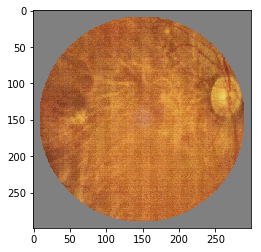

(299, 299, 3) 0


In [83]:
n = 1212
plt.imshow(X_train[n][:,:,::-1])
plt.show()
print(X_train[n].shape, y_train[n])

In [42]:
X_train = np.array(X_train)

In [13]:
X_train.shape[0]

ValueError: Not a dataset (not a dataset)

--------
- 18394
- 8:2
- clahe
- sgd
- lr 0.1 reduce 0.5
- batch 40
- epoch 1000
- augment ±10,30
- imagenet

----Inception-----


In [1]:
import h5py
with h5py.File("./different_networks/Xy.h5", "r") as f:
#     print(f.file)
    X_train = np.array(f['X'])
    y_train = np.array(f["y"])

OSError: Unable to open file (unable to open file: name = './different_networks/Xy.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [8]:
# sum(y_train[0:14715])
sum(y_train[14715:])

1831

In [5]:
X_train.shape

(18394, 299, 299, 3)

In [27]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

base_model = InceptionV3(include_top = False, 
                               weights = None)
# base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
# for layer in model.layers[:249]:
#     layer.trainable = False
# for layer in model.layers[249:]:
#     layer.trainable = True
for layer in model.layers:
    layer.trainable = True


In [37]:
def train_model_big(model,data,label,batch_size,epoch,lr,model_save_path,log_dir):
    """Train model
    Args: 
        model: a keras model
        data: image data array
        label: label array (without one-hot encoder)
        batch_size
        lr: learning rate
    Return:
        a keras History object
    """
    
    optimizer = keras.optimizers.SGD(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    from keras.utils.np_utils import to_categorical
    label = to_categorical(label, num_classes=2)
    index = int(data.shape[0] * 0.8)
    
    train_X = data[0:index]
    train_y = label[0:index]
    
    valid_X = data[index:]
    valid_y = label[index:]
    
#     flow(self, X, y, batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png')
    train_gen = ImageDataGenerator(rotation_range=30, 
                         width_shift_range= 10.0, 
                         height_shift_range= 10.0, 
                         rescale=1/255)
    valid_gen = ImageDataGenerator(rescale=1/255)
    
    train_generator = train_gen.flow(train_X, 
                     train_y, 
                     batch_size=batch_size, 
                     shuffle=True)
    valid_generator = valid_gen.flow(valid_X, valid_y, batch_size = batch_size)
    
    
#     keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

    tf_record = keras.callbacks.TensorBoard(log_dir=log_dir)
    model_check = keras.callbacks.ModelCheckpoint(filepath = model_save_path, 
                                                  monitor='val_loss', 
                                                  verbose=0, 
                                                  save_best_only=True, 
                                                  save_weights_only=False, mode='auto', period=1)
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

    his = model.fit_generator(train_generator, 
                        steps_per_epoch = train_X.shape[0] // batch_size, 
                        epochs=epoch,
                        validation_data=valid_generator, 
                        validation_steps= valid_X.shape[0] // batch_size, 
                        callbacks = [tf_record, model_check, reduce_lr])
    
    return model,his

In [57]:
for i,layer in enumerate(model.layers):
    print(i,"--->",layer.name,"--->",layer.input_shape,"--->",layer.output_shape)

0 ---> input_5 ---> (None, None, None, 3) ---> (None, None, None, 3)
1 ---> conv2d_486 ---> (None, None, None, 3) ---> (None, None, None, 32)
2 ---> batch_normalization_486 ---> (None, None, None, 32) ---> (None, None, None, 32)
3 ---> activation_486 ---> (None, None, None, 32) ---> (None, None, None, 32)
4 ---> conv2d_487 ---> (None, None, None, 32) ---> (None, None, None, 32)
5 ---> batch_normalization_487 ---> (None, None, None, 32) ---> (None, None, None, 32)
6 ---> activation_487 ---> (None, None, None, 32) ---> (None, None, None, 32)
7 ---> conv2d_488 ---> (None, None, None, 32) ---> (None, None, None, 64)
8 ---> batch_normalization_488 ---> (None, None, None, 64) ---> (None, None, None, 64)
9 ---> activation_488 ---> (None, None, None, 64) ---> (None, None, None, 64)
10 ---> max_pooling2d_17 ---> (None, None, None, 64) ---> (None, None, None, 64)
11 ---> conv2d_489 ---> (None, None, None, 64) ---> (None, None, None, 80)
12 ---> batch_normalization_489 ---> (None, None, None, 80)

In [25]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [22]:
model_save_path = './different_networks/model/inception/weights.{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}.hdf5'
model, his= train_model_big(model,X_train,y_train,40,1000,0.1,
                            model_save_path = model_save_path,
                            log_dir = './different_networks/logs/inception/')

Epoch 1/1000
367/367 [==============================] - 215s 586ms/step - loss: 0.1211 - acc: 0.9636 - val_loss: 0.0517 - val_acc: 0.9887
Epoch 2/1000
367/367 [==============================] - 215s 586ms/step - loss: 0.0580 - acc: 0.9867 - val_loss: 0.0461 - val_acc: 0.9907
Epoch 3/1000
367/367 [==============================] - 216s 589ms/step - loss: 0.0491 - acc: 0.9895 - val_loss: 0.0592 - val_acc: 0.9887
Epoch 4/1000
367/367 [==============================] - 211s 576ms/step - loss: 0.0457 - acc: 0.9887 - val_loss: 0.0491 - val_acc: 0.9907
Epoch 5/1000
367/367 [==============================] - 212s 577ms/step - loss: 0.0382 - acc: 0.9898 - val_loss: 0.0605 - val_acc: 0.9896
Epoch 6/1000
367/367 [==============================] - 210s 573ms/step - loss: 0.0329 - acc: 0.9909 - val_loss: 0.0751 - val_acc: 0.9854
Epoch 7/1000
367/367 [==============================] - 435s 1s/step - loss: 0.0291 - acc: 0.9924 - val_loss: 0.0552 - val_acc: 0.9909
Epoch 8/1000
367/367 [===============

367/367 [==============================] - 240s 655ms/step - loss: 1.7657e-05 - acc: 1.0000 - val_loss: 0.0880 - val_acc: 0.9931
Epoch 117/1000
367/367 [==============================] - 590s 2s/step - loss: 7.4076e-06 - acc: 1.0000 - val_loss: 0.1155 - val_acc: 0.9904
Epoch 118/1000
367/367 [==============================] - 578s 2s/step - loss: 6.5041e-06 - acc: 1.0000 - val_loss: 0.1004 - val_acc: 0.9923
Epoch 119/1000
367/367 [==============================] - 583s 2s/step - loss: 3.6479e-05 - acc: 1.0000 - val_loss: 0.1126 - val_acc: 0.9909
Epoch 120/1000
367/367 [==============================] - 579s 2s/step - loss: 5.1120e-06 - acc: 1.0000 - val_loss: 0.1241 - val_acc: 0.9901
Epoch 121/1000
367/367 [==============================] - 583s 2s/step - loss: 1.5209e-05 - acc: 1.0000 - val_loss: 0.0880 - val_acc: 0.9929
Epoch 122/1000
367/367 [==============================] - 582s 2s/step - loss: 9.4966e-06 - acc: 1.0000 - val_loss: 0.0902 - val_acc: 0.9926
Epoch 123/1000
367/367 [=

KeyboardInterrupt: 

In [23]:
model.save('./different_networks/model/weights.165-0.099-0.9920.hdf5')

In [28]:
gc.collect()

355

------
- 18394
- 8:2
- clahe
- sgd
- lr 0.1 reduce 0.5
- batch 40
- epoch 1000
- augment ±10,30
- imagenet = None

In [8]:
train_X = X_train[0:14715]
train_y = y_train[0:14715]
valid_X = X_train[14715:]
valid_y = y_train[14715:]
valid_X = valid_X / 255

In [29]:
def train_model_big_no_gen(model,train_X,train_y,valid_X,valid_y,batch_size,epoch,lr,model_save_path,log_dir):
    """Train model
    Args: 
        model: a keras model
        data: image data array
        label: label array (without one-hot encoder)
        batch_size
        lr: learning rate
    Return:
        a keras History object
    """
    
    optimizer = keras.optimizers.SGD(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    from keras.utils.np_utils import to_categorical
    train_y = to_categorical(train_y, num_classes=2) 
    valid_y = to_categorical(valid_y, num_classes=2)
#     flow(self, X, y, batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png')
    train_gen = ImageDataGenerator(rotation_range=30, 
                         width_shift_range= 10.0, 
                         height_shift_range= 10.0, 
                         rescale=1/255)
    
    train_generator = train_gen.flow(train_X, 
                     train_y, 
                     batch_size=batch_size, 
                     shuffle=True)
#     keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

    tf_record = keras.callbacks.TensorBoard(log_dir=log_dir)
    model_check = keras.callbacks.ModelCheckpoint(filepath = model_save_path, 
                                                  monitor='val_loss', 
                                                  verbose=0, 
                                                  save_best_only=True, 
                                                  save_weights_only=False, mode='auto', period=1)
    
#     reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience = 5)

    his = model.fit_generator(train_generator, 
                        steps_per_epoch = train_X.shape[0] // batch_size, 
                        epochs=epoch,
                        validation_data=(valid_X,valid_y),
#                         callbacks = [tf_record, model_check, reduce_lr])
                        callbacks = [tf_record, model_check])
    
    return model,his

In [30]:
model, his = train_model_big_no_gen(model,
                                    train_X,train_y,
                                    valid_X,valid_y,
                                    40,100,0.1,
                                    './different_networks/model/inception_no/weights.{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
                                    './different_networks/logs/inception_no')

Epoch 1/100
367/367 [==============================] - 239s 652ms/step - loss: 0.2451 - acc: 0.9024 - val_loss: 0.1443 - val_acc: 0.9456
Epoch 2/100
367/367 [==============================] - 203s 554ms/step - loss: 0.1179 - acc: 0.9601 - val_loss: 0.0911 - val_acc: 0.9690
Epoch 3/100
367/367 [==============================] - 195s 531ms/step - loss: 0.0933 - acc: 0.9716 - val_loss: 0.1323 - val_acc: 0.9592
Epoch 4/100
367/367 [==============================] - 200s 546ms/step - loss: 0.0818 - acc: 0.9772 - val_loss: 0.0945 - val_acc: 0.9693
Epoch 5/100
367/367 [==============================] - 207s 563ms/step - loss: 0.0770 - acc: 0.9792 - val_loss: 0.0788 - val_acc: 0.9772
Epoch 6/100
367/367 [==============================] - 196s 534ms/step - loss: 0.0662 - acc: 0.9825 - val_loss: 0.0686 - val_acc: 0.9829
Epoch 7/100
367/367 [==============================] - 196s 533ms/step - loss: 0.0656 - acc: 0.9825 - val_loss: 0.0596 - val_acc: 0.9851
Epoch 8/100
367/367 [====================

In [31]:
import pickle
with open('./different_networks/his_inception_no_lr.pkl','wb') as f:
    pickle.dump(his.history,f)

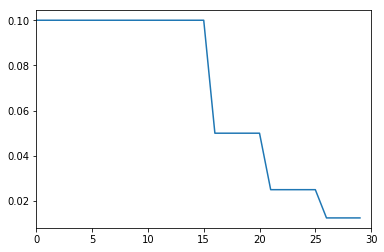

In [21]:
# plt.plot(his.history['val_acc'][0:30])
plt.plot(his.history['lr'][0:30])
plt.xlim((0,30))
plt.show()

In [19]:
import pickle
with open('./different_networks/his_inception_no.pkl', 'rb') as f:
    h = pickle.load(f)

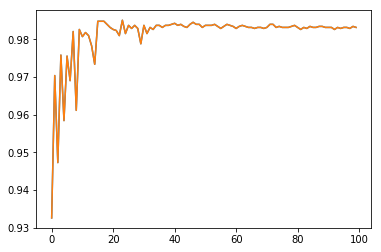

In [26]:
plt.plot(h['val_acc'])
plt.show()

In [30]:
h['val_acc'][15]

0.9847784768825447

In [23]:
h['val_loss'][15]

0.07281460523803812

## 结果分析

- 本部分需要用到：
    - 混淆矩阵
    - 临床分析